In [1]:
#importo le librerie necessarie
import numpy as np
import pandas as pd

#definisco l'algoritmo come una classe
class Perceptron(object):
    
    #inizializzatore
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    #funzione per il fitting dei dati di training
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal (loc=0.0, scale=0.01, size=1+X.shape[1])
        
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    #funzione per calcolare il net input
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    #funzione per predire i valori delle y
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
        

In [2]:
#import del dataset di training
dataset = pd.read_excel(r"C:\Users\fspadafora\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\Desktop\KAGGLE\spaceship-titanic\train_split.xlsx")

In [3]:
#import del dataset di test
df_test = pd.read_excel(r"C:\Users\fspadafora\OneDrive - BUSINESS INTEGRATION PARTNERS SPA\Desktop\KAGGLE\spaceship-titanic\test_split.xlsx")

In [4]:
#trasformo la variabile target del trainng da 0/1 a 1/-1
dataset['Transported'] = np.where(dataset['Transported'] == 0, -1, 1)

In [19]:
#trasformo la variabile target del test da 0/1 a 1/-1
df_test['Transported'] = np.where(df_test['Transported'] == 0, -1, 1)

In [5]:
#standardizzo le variabili
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#training
dataset[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T'
   ]] = scaler.fit_transform(dataset[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T']])

#test
df_test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T'
   ]] = scaler.fit_transform(df_test[['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt','ShoppingMall', 'Spa', 'VRDeck', 'Earth', 
    'Europa','Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 'P', 'S', 'A','B', 'C', 'D', 'E', 'F', 'G', 'T']])

In [23]:
#preparo i vettori X e y di training
y_ = dataset.iloc[0:, 8].values
y = y_.reshape(len(y_), 1)
X1 = dataset.iloc[0:, 0:7].values
X2 = dataset.iloc[0:, 9:].values
X = np.concatenate((X1,X2), axis=1)

#preparo i vettori X e y di test
X1t = df_test.iloc[0:, 0:7].values
X2t = df_test.iloc[0:, 9:].values
Xt = np.concatenate((X1t,X2t), axis=1)

y_t = df_test.iloc[0:, 8].values
yt = y_t.reshape(len(y_t), 1)

In [22]:
yt.shape

(6085, 1)

In [7]:
#inizializzo un'istanza della classe Perceptron (ovvero dell'algoritmo)
p = Perceptron(0.01, 255, 1)

In [8]:
#lancio la funzione per il training del modello
p.fit(X, y)

In [9]:
#valuto lo score sul training
score = 1 - (p.errors_[(len(p.errors_) - 1)] / dataset.shape[0])
score

0.6752670501232538

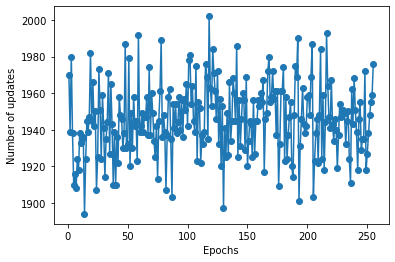

In [10]:
#plot the misclassification error for each epoch to check whether the algorithm converged and found a decision boundary
import matplotlib.pyplot as plt
plt.plot(range(1, len(p.errors_) + 1),
p.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

In [11]:
#invoco la funzione predict per predire i valori di 'Transported' del Test set
prediction = p.predict(Xt)

In [12]:
#calcolo lo score di test
correct = 0
for p1,p2 in zip(prediction, df_test['Transported']):
    if p1 == p2: 
        correct += 1
score = correct/len(prediction)
score

0.34700920245398775

In [26]:
#implementazione del Perceptron di sklearn come termine di paragone
from sklearn.linear_model import Perceptron
clf = Perceptron(tol=1e-3, random_state=0, eta0 = 0.01)
clf.fit(X, y)
Perceptron()
clf.score(X, y)

C:\Users\fspadafora\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.723582580115037

In [25]:
#score di test dell'algoritmo
clf.score(Xt, yt)

0.7181748466257669